# Experimental results

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import seaborn as sns
import tables as tb
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

## Initial data

In [6]:
farm_names = ['Oahu', 'Almeria']
input_paths = []
sensor_names = {}
sensor_latitudes = {}
sensor_longitudes = {}
for f in range(len(farm_names)):
    farm_name = farm_names[f]
    input_path = f'../data/input/{farm_name}/sensors_data.h5'
    input_paths.append(input_path)
    input_table = tb.open_file(input_path, 'r')
    info_group = input_table.get_node('/', 'info')
    sensor_names_aux: tb.Array = input_table.get_node(info_group, 'sensor_names')
    sensor_names[farm_name] = [name.decode() for name in sensor_names_aux]
    sensor_latitudes[farm_name]: tb.Array = input_table.get_node(info_group, 'sensor_latitudes')
    sensor_longitudes[farm_name]: tb.Array = input_table.get_node(info_group, 'sensor_longitudes')
    input_table.close()
output_paths = ['../data/output/DataCenter/Oahu/oahu.h5', '../data/output/DataCenter/Almeria/almeria.h5']

## Monitoring

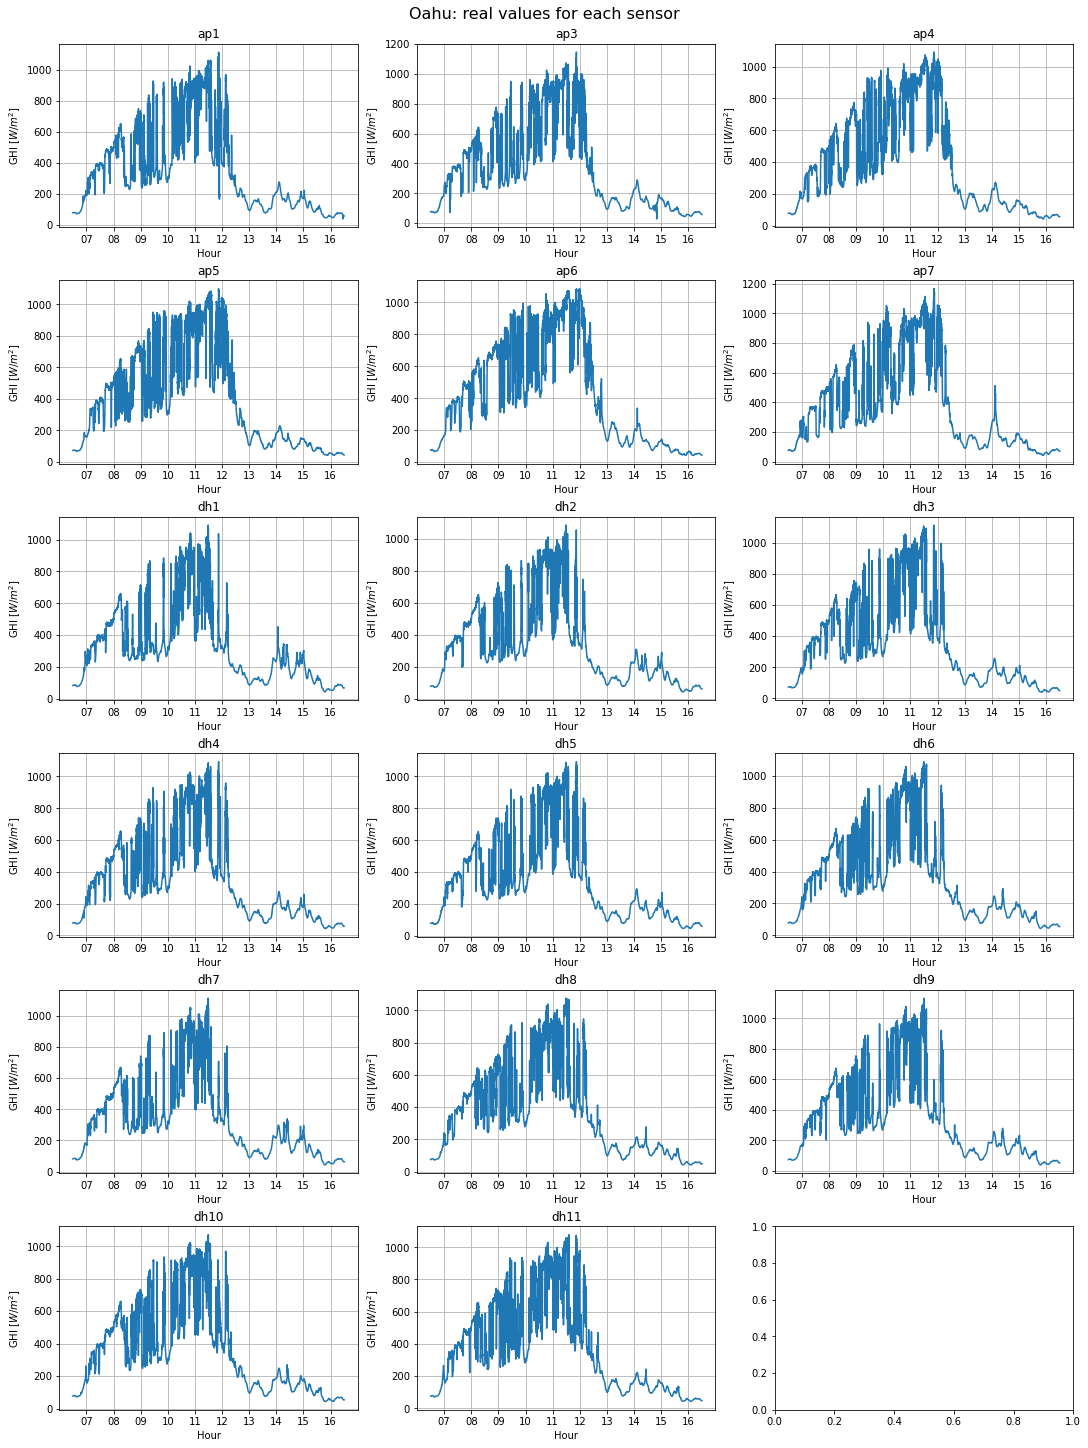

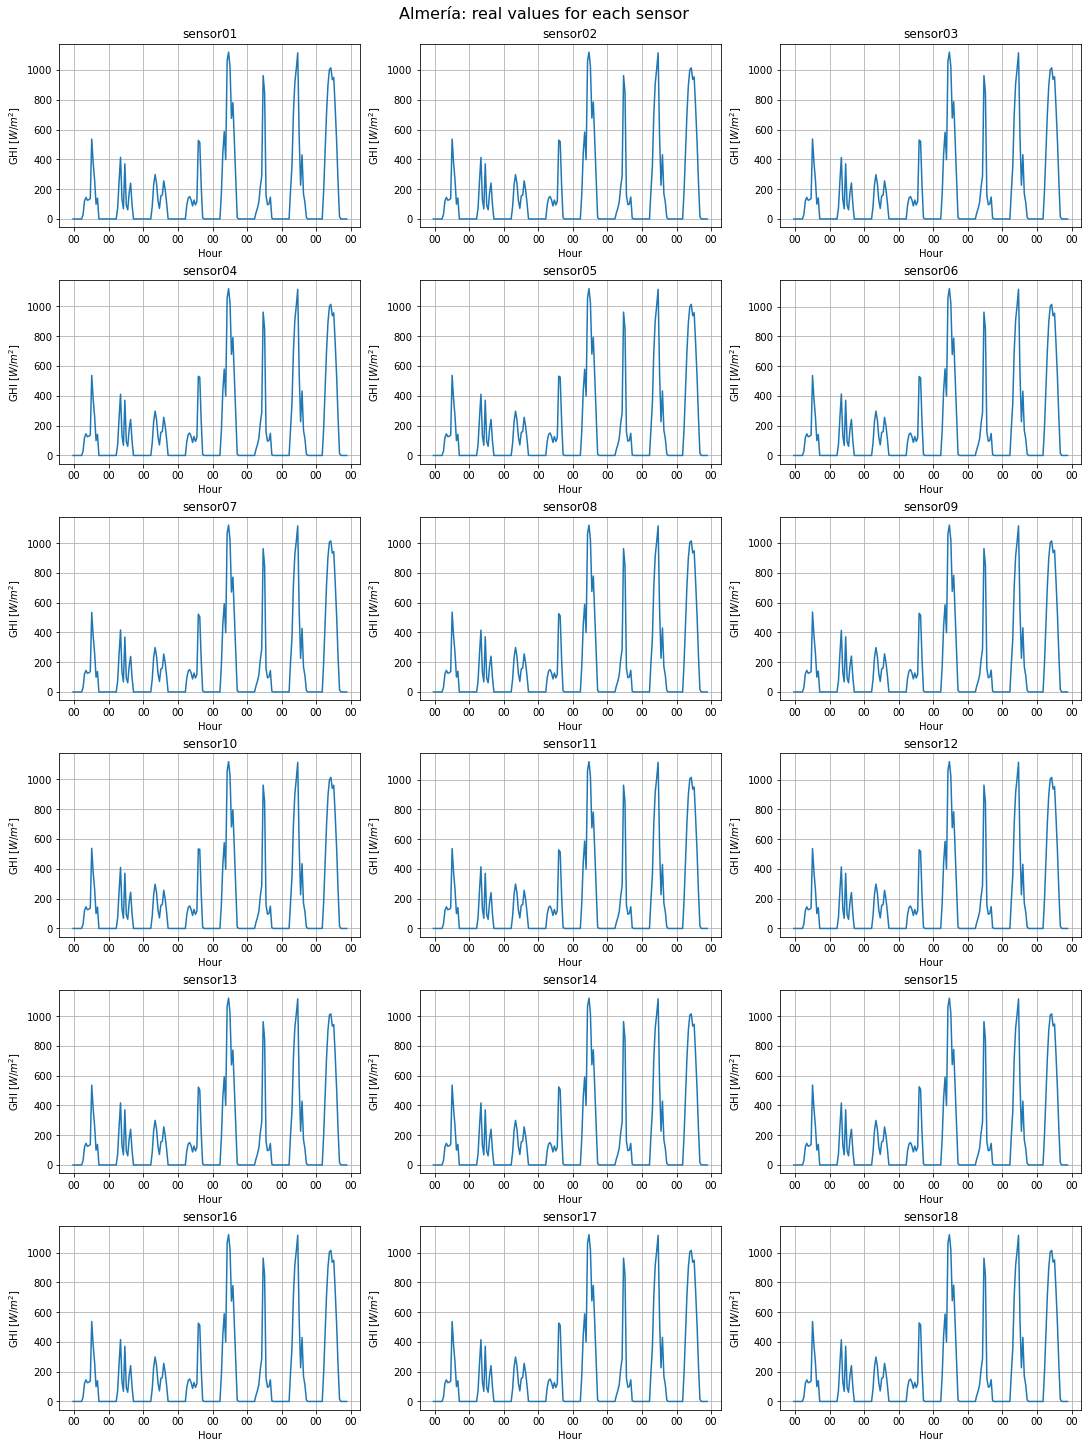

In [7]:
farm_names_es = ['Oahu', 'Almería']
start_dts = [dt.datetime.strptime("2010-03-22 00:00:01", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-22 00:00:01", "%Y-%m-%d %H:%M:%S")]
stop_dts = [dt.datetime.strptime("2010-03-22 23:59:59", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-29 23:59:59", "%Y-%m-%d %H:%M:%S")]
for f in range(len(farm_names)):
    farm_name = farm_names[f]
    output_path = output_paths[f]
    output_table = tb.open_file(output_path, 'r')
    fig,ax = plt.subplots(6,3, figsize=(15,20),constrained_layout = True)
    fig.suptitle(f'{farm_names_es[f]}: real values for each sensor', fontsize=16)
    for s in range(len(sensor_names[farm_name])):
        sensor_table = output_table.get_node(f'/DataCenter/{farm_name}/{sensor_names[farm_name][s]}')
        df = pd.DataFrame.from_records(sensor_table.read_where(f"(timestamp>={start_dts[f].timestamp()}) & (timestamp<{stop_dts[f].timestamp()})"))
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
        ax[s//3,s%3].set_title(sensor_names[farm_name][s])
        ax[s//3,s%3].plot(df.timestamp, df.radiation)
        ax[s//3,s%3].xaxis.set_major_formatter(mdates.DateFormatter('%H'))
        ax[s//3,s%3].grid()
        ax[s//3,s%3].set_ylabel('GHI $[W/m^2]$')
        ax[s//3,s%3].set_xlabel('Hour') #, fontsize=12)
    fig.savefig(f'{farm_names[f]}-monitoring.png', dpi=400, bbox_inches='tight')
    output_table.close()

## Outliers detection

10:55:15 - cmdstanpy - INFO - Chain [1] start processing
10:55:35 - cmdstanpy - INFO - Chain [1] done processing


The MAE for the model is 78.33521601708459
The MAPE for the model is 0.2526867412584017
Number of outliers: 1112


ValueError: Dataframe has less than 2 non-NaN rows.

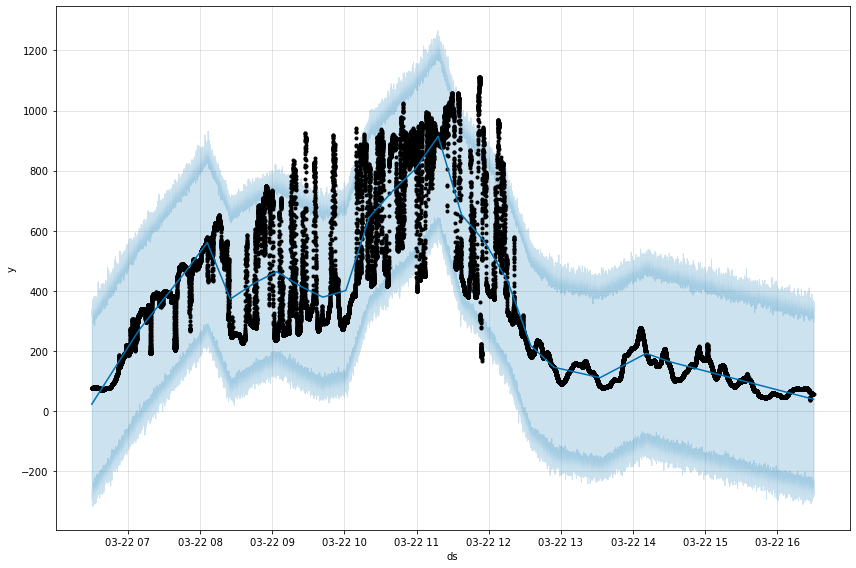

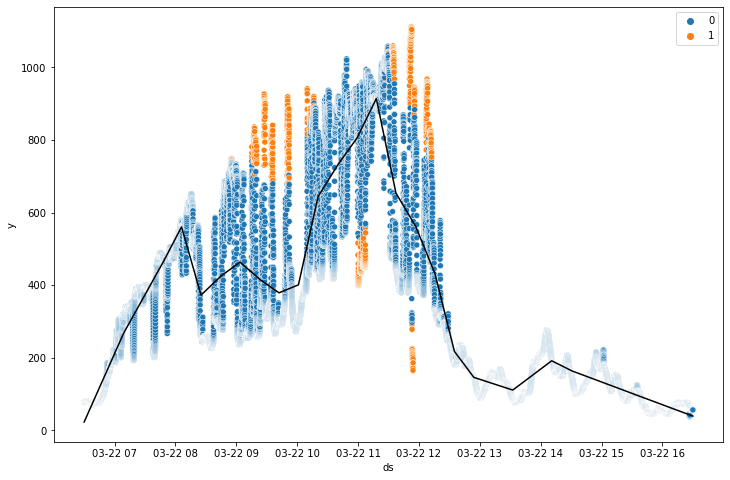

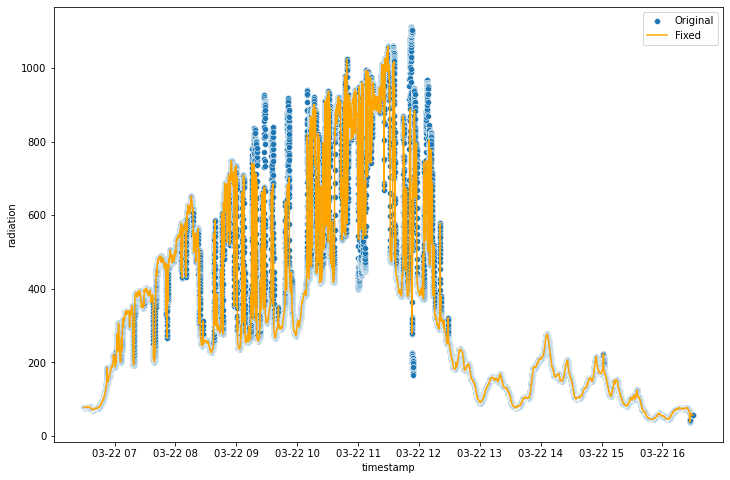

In [14]:
sensors_test = ['ap1', 'sensor01']
start_dts = [dt.datetime.strptime("2010-03-22 00:00:01", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-26 23:59:59", "%Y-%m-%d %H:%M:%S")]
stop_dts = [dt.datetime.strptime("2010-03-22 23:59:59", "%Y-%m-%d %H:%M:%S"), dt.datetime.strptime("2020-03-26 23:59:59", "%Y-%m-%d %H:%M:%S")]
for f in range(2):
    h5 = tb.open_file(output_paths[f], 'r')
    sensor_table = h5.get_node(f'/DataCenter/{farm_names[f]}/{sensors_test[f]}')
    df = pd.DataFrame.from_records(sensor_table.read_where(f"(timestamp>={start_dts[f].timestamp()}) & (timestamp<{stop_dts[f].timestamp()})"))
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    
    # Preparing the model ..."
    data = df.rename(columns={"timestamp": "ds", "radiation": "y"})
    model = Prophet(interval_width=0.99)
    model.fit(data)
    
    # Making prediction ...
    forecast = model.predict(data)
    fig1 = model.plot(forecast, figsize=(12,8)); # Add semi-colon to remove the duplicated chart
    fig1.savefig(f'{farm_names[f]}-prophet-forecast.png', dpi=400, bbox_inches='tight')

    # Merge actual and predicted values, show MAE and MAPE
    performance = pd.merge(data, forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')
    performance_MAE = mean_absolute_error(performance['y'], performance['yhat'])
    print(f'The MAE for the model is {performance_MAE}')
    performance_MAPE = mean_absolute_percentage_error(performance['y'], performance['yhat'])
    print(f'The MAPE for the model is {performance_MAPE}')
    
    # Create an anomaly indicator. Visualize
    performance['anomaly'] = performance.apply(lambda rows: 1 if ((rows.y<rows.yhat_lower)|(rows.y>rows.yhat_upper)) else 0, axis = 1)
    num_outliers = performance['anomaly'].value_counts()[1]
    print("Number of outliers: " + str(num_outliers))
    if num_outliers < 2:
        print("No outliers found")
        continue
    fig2 = plt.figure(figsize=(12,8))
    ax = sns.scatterplot(x='ds', y='y', data=performance, hue='anomaly')
    sns.lineplot(x='ds', y='yhat', data=performance, color='black', ax=ax)
    fig2.savefig(f'{farm_names[f]}-prophet-outliers.png', dpi=400, bbox_inches='tight')
    
    # Compute fixed values
    df_fixed = df.copy()
    df_fixed.reset_index(inplace=True)
    idx = performance.index[performance['anomaly'] == 1].tolist()
    for id in idx:
        df_fixed.loc[id, 'radiation'] = np.nan
    df_fixed['radiation'].interpolate(method="linear", inplace=True)
    fig3 = plt.figure(figsize=(12,8))
    ax = sns.scatterplot(x='timestamp', y='radiation', data=df, label='Original')
    sns.lineplot(x='timestamp', y='radiation', data=df_fixed, color='orange', label='Fixed', ax=ax)
    fig3.savefig(f'{farm_names[f]}-prophet-outliers-fixed.png', dpi=400, bbox_inches='tight')

    h5.close()

We must run another simulation to detect and fix outliers:

Commander::o_cmd -> 2010-03-23 18:10:00;FIX_OUTLIERS
Fog server received command to fix outliers with arguments: ['DataCenter', 'Oahu', 'ap1', '2010-03-22 07:30:00', '2010-03-22 17:30:00', 'linear', 'simulation.h5'] ...
Reading H5 data ...
Preparing the model ...


17:54:38 - cmdstanpy - INFO - Chain [1] start processing
17:54:55 - cmdstanpy - INFO - Chain [1] done processing


Making prediction ...
The MAE for the model is 78.33521601708459
The MAPE for the model is 0.2526867412584017
Number of outliers: 0    34907
1     1093
Name: anomaly, dtype: int64


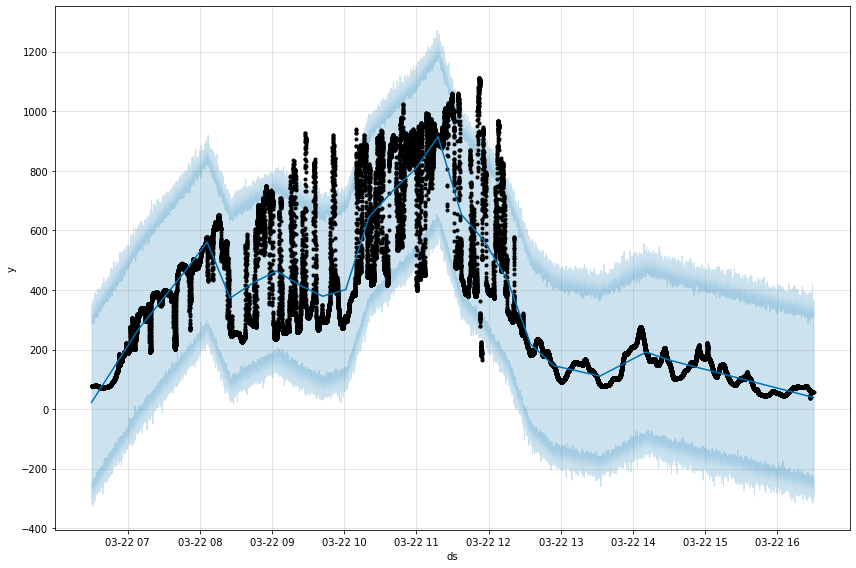

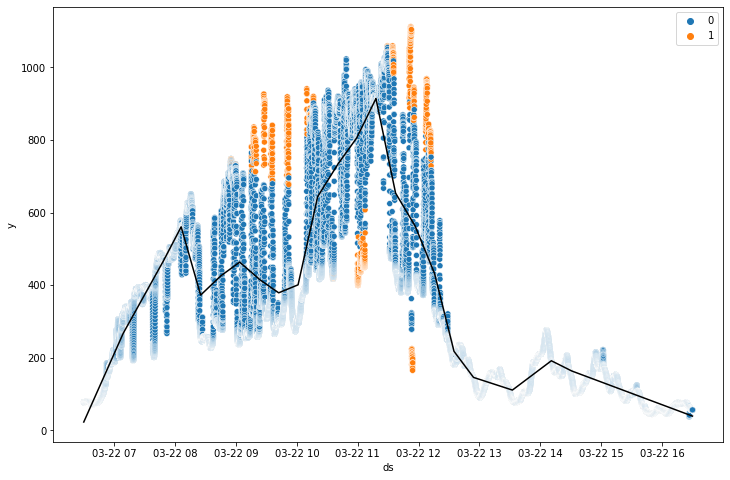

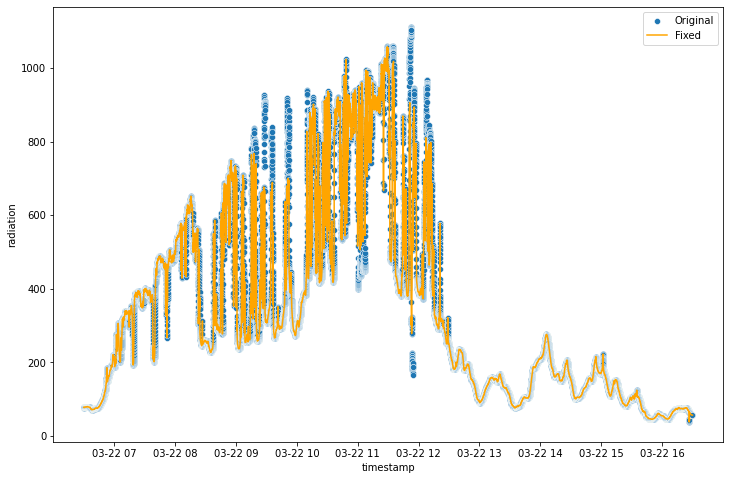

In [6]:
random.seed(1975)
coupled = SingleFarmOahu("oahu-outliers.txt", "../data")
coord = Coordinator(coupled)
coord.initialize()
coord.simulate_time(INFINITY)
coord.exit()

## Prediction service

Finally, we launch the prediction service repeating the process. Note that everything can be done using just one simulation file. However, we are splitting the process for simiplicity.

The simulation file to execute the prediction service is as follows. The first line transform the output of the simulation into an H5 file needed by the prediction library. Next, the inference itself is executed:

In [7]:
%%writefile ../data/input/simulations/oahu-prediction.txt
DATETIME;COMMAND;ARGUMENTS
2010-03-22 18:00:00;CMD_PREPARE_PREDICTION;DataCenter;Oahu;2010-03-22 07:30:00;2010-03-22 17:30:00;60;simulation.h5;prediction-input.h5;
2010-03-22 18:01:00;CMD_RUN_PREDICTION;DataCenter;Oahu;2010-03-22 07:30:00;2010-03-22 17:30:00;2010-03-22 16:00:00;510;prediction-input.h5;prediction-output.h5;

Writing ../data/input/simulations/oahu-prediction.txt


We are ready now to launch the simulation:

Commander::o_cmd -> 2010-03-22 18:00:00;PREPARE_PREDICTION
Fog server received command to generate the H5 file with arguments: ['DataCenter', 'Oahu', '2010-03-22 07:30:00', '2010-03-22 17:30:00', '60', 'simulation.h5', 'prediction-input.h5'] ...
Commander::o_cmd -> 2010-03-22 18:01:00;RUN_PREDICTION
Fog server received command to generate prediction with arguments: ['DataCenter', 'Oahu', '2010-03-22 07:30:00', '2010-03-22 17:30:00', '2010-03-22 16:00:00', '510', 'prediction-input.h5', 'prediction-output.h5'] ...


/home/jlrisco/.local/lib/python3.10/site-packages/tables/path.py:137: NaturalNameWarning:

object name is not a valid Python identifier: '2010-03-22'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though

2023-02-14 17:55:56.026932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-14 17:55:56.026950: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-14 17:55:56.026979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pc-toshiba): /proc/driver/nvidia/version does not exist
2023-02-14 17:55:56.027172: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorF

Unable to forecast at times before 07:40 and after 16:29
Prediction successful! it took 00:00:05 in total


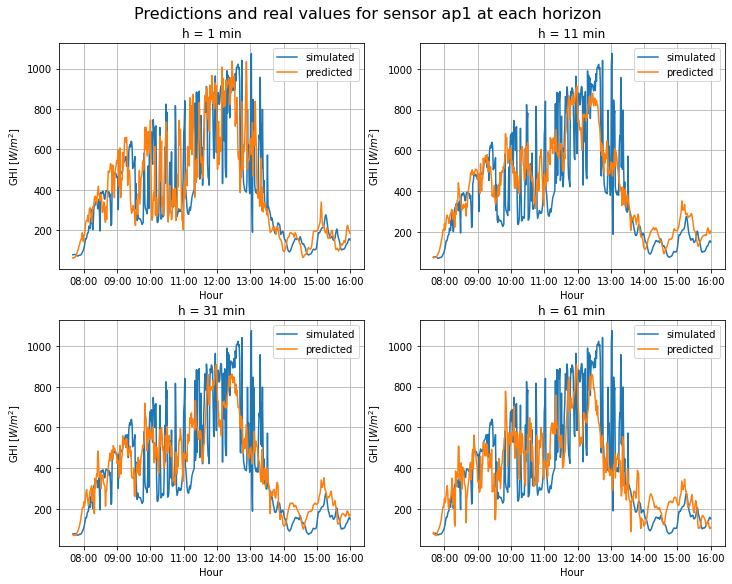

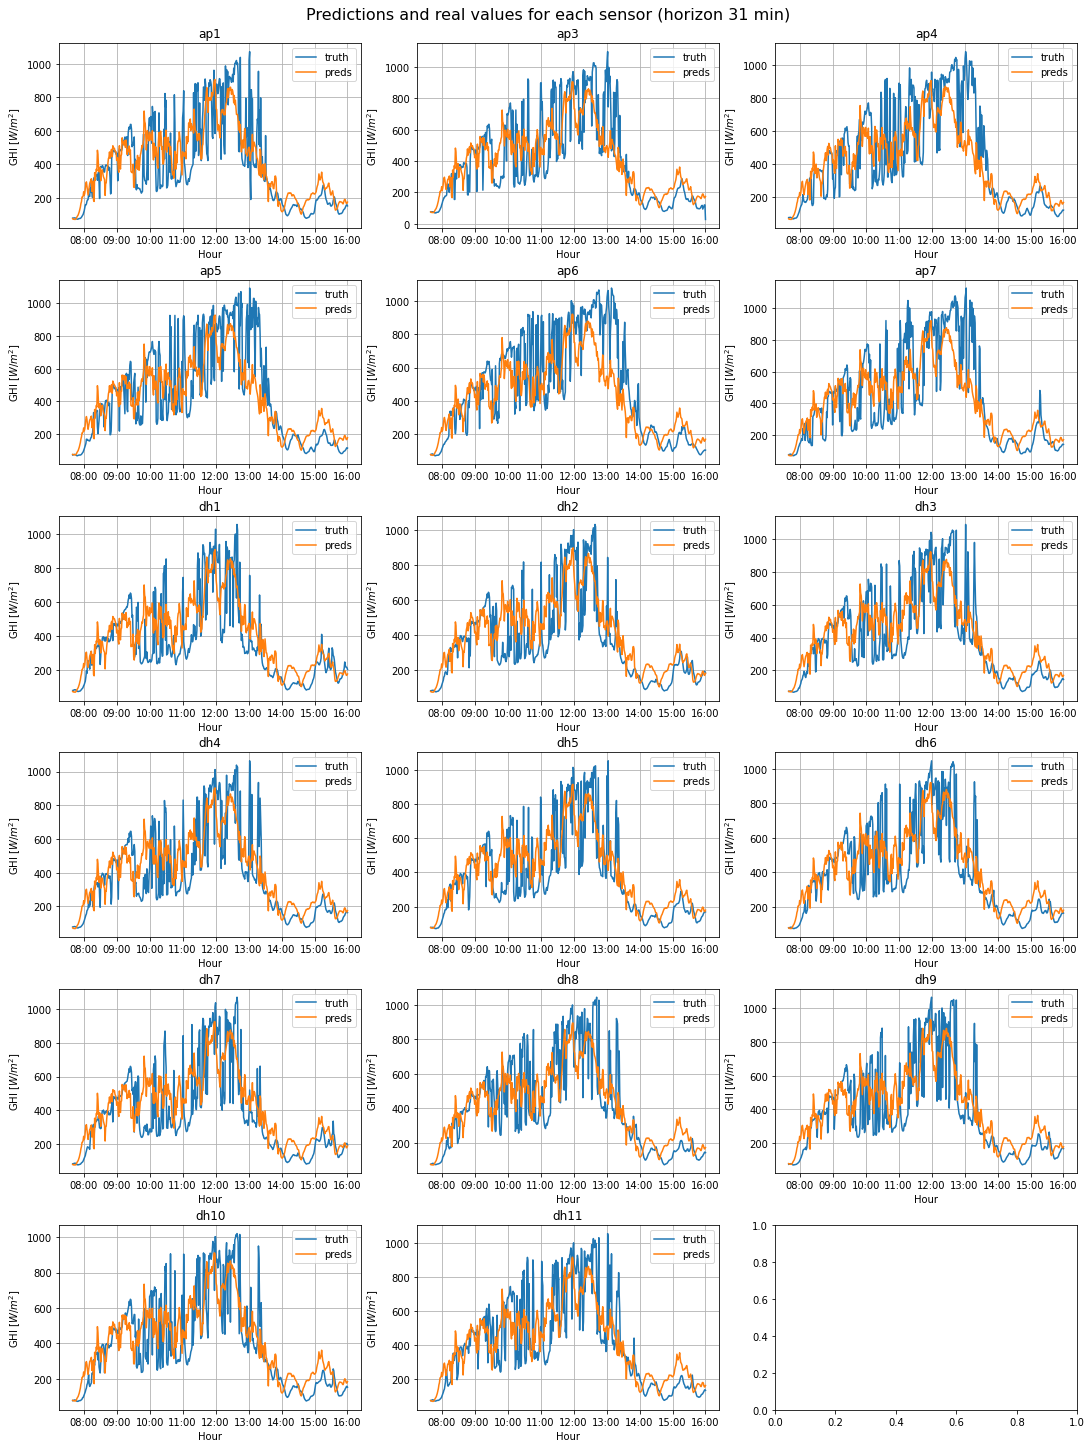

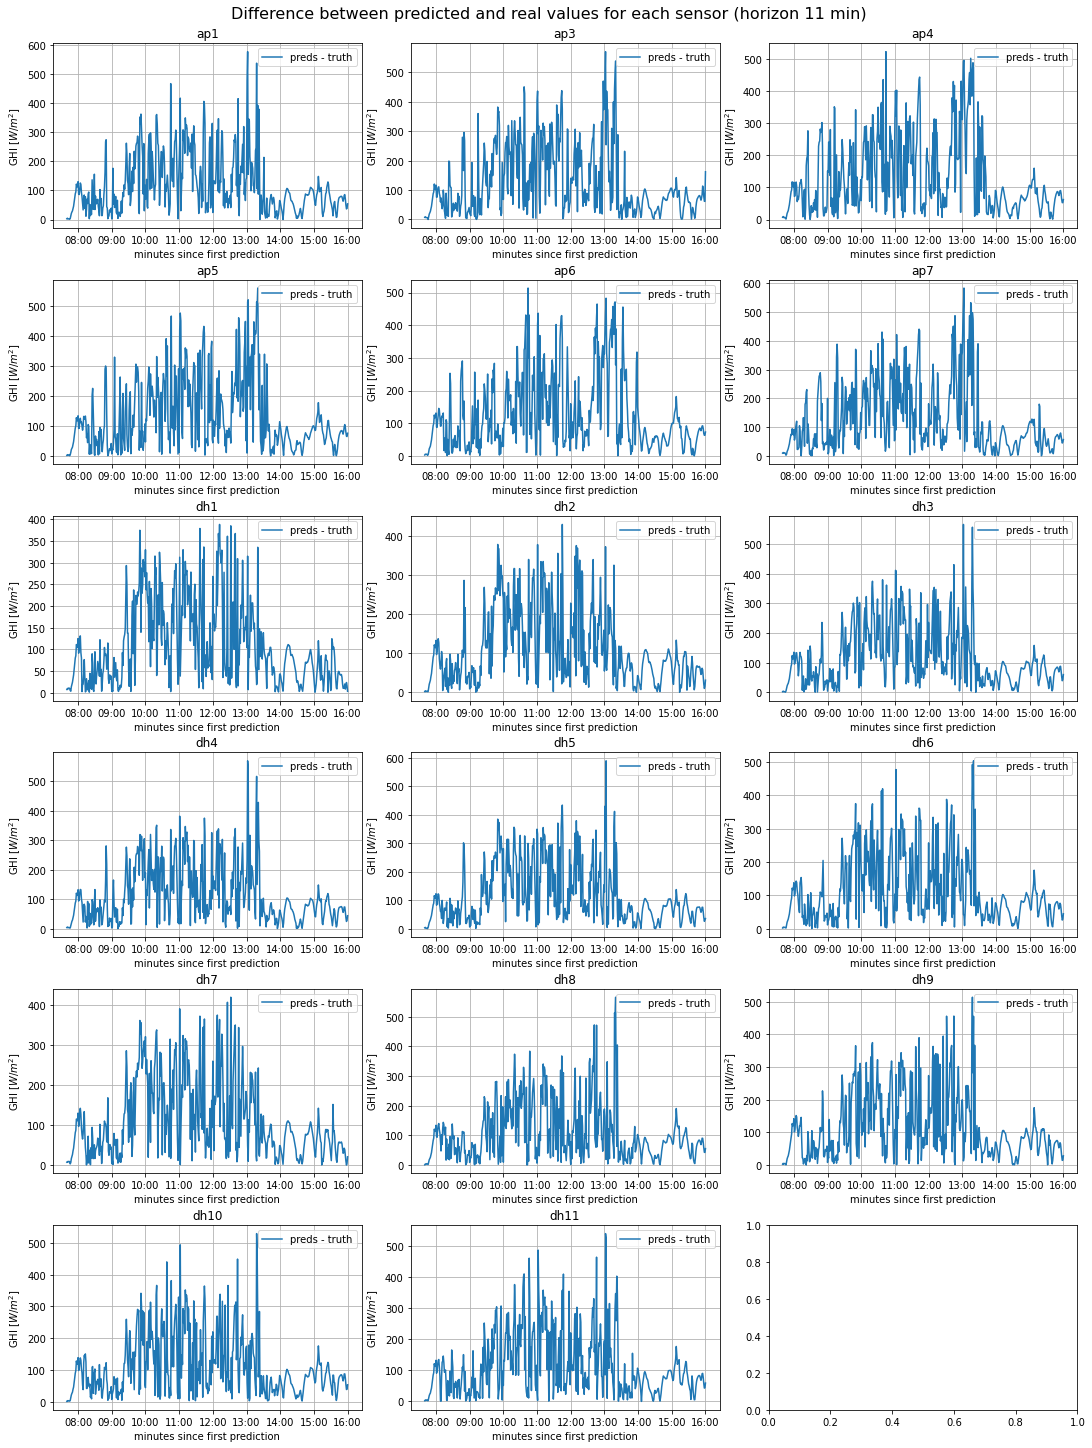

In [8]:
random.seed(1975)
coupled = SingleFarmOahu("oahu-prediction.txt", "../data")
coord = Coordinator(coupled)
coord.initialize()
coord.simulate_time(INFINITY)
coord.exit()